## **Model Prototyping**

This notebook builds and evaluates initial text classification models  
to detect spoiler vs non-spoiler reviews.

Baseline models tested:
- Multinomial Naive Bayes
- Logistic Regression


In [1]:
import nltk
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score, f1_score
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import precision_recall_fscore_support
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/rickin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/rickin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rickin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_feather("../data/preprocessed_reviews.feather")

### Adding Features
- `word_count`
- `has_spoiler_tag`
- `sentence_count`
- `full_text`

In [3]:
# df["word_count"] = df["review_text"].apply(len)
df["has_spoiler_tag"] = df["review_text"].apply(lambda x : "spoiler" in x)
df["review_text_str"] = df["review_text"].astype(str)
df["review_summary_str"] = df["review_summary"].astype(str)
df["full_text"] = df["review_summary_str"] + " " + df["review_text_str"]
# df["sentence_count"] = df["review_text_str"].apply(lambda x: len(sent_tokenize(x)))
# df["avg_sentence_length"] = df["word_count"] / (df["sentence_count"] + 1e-6)

### Splitting the data for training and testing

In [5]:
# X = df[["full_text", "word_count", "has_spoiler_tag", "sentence_count", "avg_sentence_length"]]
X = df[["full_text", "has_spoiler_tag"]]
y = df["is_spoiler"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_text = X_train["full_text"]
X_test_text = X_test["full_text"]
y_test = y_test.astype(str)

In [6]:
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])
print("Spoiler ratio (train):", y_train.value_counts(normalize=True))

Training samples: 459130
Testing samples: 114783
Spoiler ratio (train): is_spoiler
False    0.737027
True     0.262973
Name: proportion, dtype: float64


In [7]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    return " ".join(lemmatizer.lemmatize(w) for w in text.split())

X_train_clean_text = [clean_text(t) for t in X_train_text]
X_test_clean_text = [clean_text(t) for t in X_test_text]

### Vectorizing the `full_text` column

In [8]:
tfidf_full = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=3,
    max_df=0.8,
    sublinear_tf=True,
    stop_words='english'
)

X_train_tfidf = tfidf_full.fit_transform(X_train_clean_text)
X_test_tfidf = tfidf_full.transform(X_test_clean_text)

In [28]:
keywords = [
    "plot twist", "ending", "spoiler", "die", "surprise", "reveal", "betrayal",
    "twist", "kill", "death", "betray",
    "secret", "hidden truth", "big reveal", "unexpected", "shocking", "truth come out",
    "turn out", "actually", "real identity", "mask off", "double life", "deception",
    "disguise", "undercover", "false", "pretend", "plot reveal", "confession",
    "murder", "die in the end", "sacrifice", "fatal", "tragic end",
    "last scene", "final moment", "shot", "poison", "accident", "suicide",
    "dead", "death scene", "funeral", "grave",
    "turn against", "double cross", "traitor", "backstab", "deceive", "lie",
    "set up", "frame", "sell out", "enemy", "betrayal arc",
    "finale", "ending explain", "last episode", "climax", "final battle",
    "resolution", "conclusion", "credit scene", "after credit", "final twist",
    "mind blowing", "psychological", "hallucination", "dream", "illusion", "impostor",
    "gaslight", "paradox", "memory loss", "not real", "imagine", "alternate reality",
    "simulation"
]

In [29]:
tfidf_kw = TfidfVectorizer(
    vocabulary=keywords,
    ngram_range=(1, 3),
    lowercase=True
)
X_train_kw = tfidf_kw.fit_transform(X_train_clean_text)
X_test_kw = tfidf_kw.transform(X_test_clean_text)

### Putting everything together

In [30]:
# X_train_numeric = X_train[["word_count", "has_spoiler_tag", "sentence_count", "avg_sentence_length"]].copy()
X_train_numeric = X_train[["has_spoiler_tag"]].copy()
X_train_numeric["has_spoiler_tag"] = X_train_numeric["has_spoiler_tag"].astype(int)

# X_test_numeric = X_test[["word_count", "has_spoiler_tag", "sentence_count", "avg_sentence_length"]].copy()
X_test_numeric = X_test[["has_spoiler_tag"]].copy()
X_test_numeric["has_spoiler_tag"] = X_test_numeric["has_spoiler_tag"].astype(int)

In [31]:
X_train_combined = hstack([
    X_train_tfidf,
    X_train_kw,
    csr_matrix(X_train_numeric.values)
])

X_test_combined = hstack([
    X_test_tfidf,
    X_test_kw,
    csr_matrix(X_test_numeric.values)
])

## **Training with Naive Bayes**

In [32]:
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='f1')
grid.fit(X_train_combined, y_train)
print(grid.best_params_)

{'alpha': 0.01}


In [33]:
nb = MultinomialNB(alpha=grid.best_params_['alpha'])
nb.fit(X_train_combined, y_train)
nb_probs = nb.predict_proba(X_test_combined)[:, 1]

In [34]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred = (nb_probs >= t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_test.map({'False':0,'True':1}), y_pred, average='binary', zero_division=np.nan)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1-Score: {best_f1:.4f}")


Best Threshold: 0.26
Best F1-Score: 0.5298


              precision    recall  f1-score   support

       False       0.84      0.75      0.80     84598
        True       0.47      0.61      0.53     30185

    accuracy                           0.71    114783
   macro avg       0.66      0.68      0.66    114783
weighted avg       0.75      0.71      0.73    114783



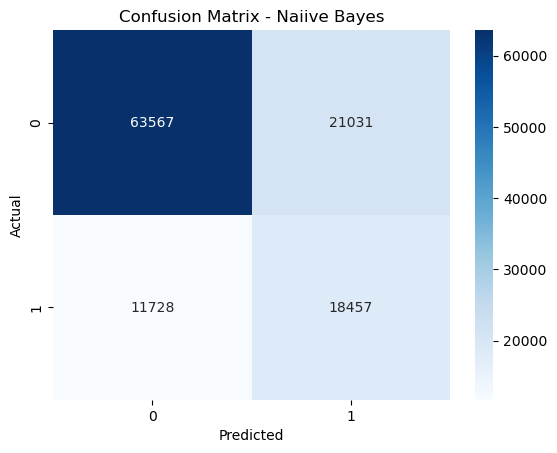

In [35]:
y_pred = np.where(nb_probs > best_threshold, 'True', 'False')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naiive Bayes")
plt.show()

In [36]:
precision_nb, recall_nb, f1_nb, _ = precision_recall_fscore_support(
    y_test.map({'False': 0, 'True': 1}),
    (y_pred == 'True').astype(int),
    average='binary',
    zero_division=np.nan
)
accuracy_nb = accuracy_score(y_test, y_pred)
macro_f1_nb = f1_score(y_test, y_pred, average='macro')

## **Training with Logistic Regression**

In [37]:
lr = LogisticRegression(
    max_iter=100,
    class_weight='balanced',
    solver='saga',
    n_jobs=-1
)
lr.fit(X_train_combined, y_train)
lr_probs = lr.predict_proba(X_test_combined)[:, 1]

In [38]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred = (lr_probs >= t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_test.map({'False':0,'True':1}), y_pred, average='binary', zero_division=np.nan)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1-Score: {best_f1:.4f}")


Best Threshold: 0.52
Best F1-Score: 0.5590


              precision    recall  f1-score   support

       False       0.86      0.77      0.81     84598
        True       0.50      0.64      0.56     30185

    accuracy                           0.73    114783
   macro avg       0.68      0.70      0.68    114783
weighted avg       0.76      0.73      0.74    114783



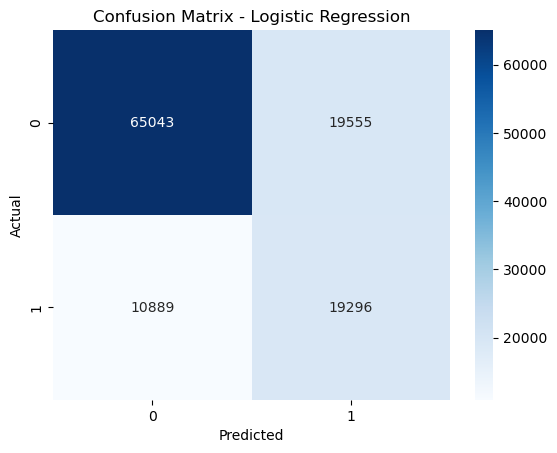

In [39]:
y_pred = np.where(lr_probs > best_threshold, 'True', 'False')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [40]:
precision_lr, recall_lr, f1_lr, _ = precision_recall_fscore_support(
    y_test.map({'False': 0, 'True': 1}),
    (y_pred == 'True').astype(int),
    average='binary',
    zero_division=np.nan
)
accuracy_lr = accuracy_score(y_test, y_pred)
macro_f1_lr = f1_score(y_test, y_pred, average='macro')

### **Comparing both the results**

In [ ]:
results = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression'],
    'Precision (Spoiler)': [round(precision_nb, 2), round(precision_lr,2)],
    'Recall (Spoiler)': [round(recall_nb,2), round(recall_lr,2)],
    'F1 (Spoiler)': [round(f1_nb,2), round(f1_lr,2)],
    'Accuracy': [round(accuracy_nb,2), round(accuracy_lr,2)],
    'Macro F1': [round(macro_f1_nb,2), round(macro_f1_lr,2)]
})

results

,Model,Precision (Spoiler),Recall (Spoiler),F1 (Spoiler),Accuracy,Macro F1
0,Naive Bayes,0.47,0.61,0.53,0.71,0.66
1,Logistic Regression,0.50,0.64,0.56,0.73,0.68
